In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
sys.path.append('/home/jma819/post_cmfe_analysis')
#sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import scipy.spatial.distance as dist
import itertools
import math
import warnings
warnings.filterwarnings(action='once')

ModuleNotFoundError: No module named 'python_utils_jjm'

In [2]:
reload(utils_jjm)
reload(dlc_utils)

<module 'dlc_utils' from '/home/jma819/post_cmfe_analysis/dlc_utils.py'>

In [3]:
#cnmfe_file_key = pd.read_csv('/volumes/My_Passport/dlc_analysis/behavcamvideos/cnmfe_file_key.csv')
cnmfe_file_key = pd.read_csv('/projects/p30771/dlc_analysis/openfield_dlc_output/cnmfe_file_key.csv')

In [4]:
#cnmfe_base_dir = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/'
cnmfe_base_dir = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/'
wt_CNMFE_file = ['30-Mar_20_39_05_out.mat', '30-Mar_20_45_16_out.mat', '27-Feb_17_33_59_out.mat', '22-Mar_22_52_02_out.mat',
                 '28-Feb_16_10_05_out.mat', '27-Feb_17_32_15_out.mat', '28-Feb_16_21_21_out.mat', '25-Mar_13_27_27_out.mat',
                 '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat']

ko_CNMFE_files = ['31-Mar_13_28_15_out.mat', '29-Mar_21_42_20_out.mat', '13-Apr_17_57_40_out.mat', '29-Mar_14_27_55_out.mat', '13-Apr_16_01_20_out.mat',
                 '13-Apr_16_11_27_out.mat', '29-Mar_13_39_44_out.mat']

In [5]:
#tracking_files = ['/volumes/My_Passport/dlc_analysis/behavcamvideos/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 
tracking_files = ['/projects/p30771/dlc_analysis/openfield_dlc_output/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 

In [6]:
CNMFE_dir_paths_list = [str(cnmfe_base_dir+fname) for fname in wt_CNMFE_file]
#CNMFE_dir_paths_list

In [53]:
grouped_raw_data = {}
success = []
failed = []
body_part ='tail_base'
numbins_per_mouse = 100

for CNMFE_file, tracking_file in zip(CNMFE_dir_paths_list, tracking_files):
    #print(CNMFE_file)
    #print(tracking_file)
    try:
        # load cell fluorescence 
        cell_fluorescence = sio.loadmat(CNMFE_file)
        C_timedelta = utils_jjm.create_fluorescence_time_delta(cell_fluorescence['C'])
        C_normalized = C_timedelta.apply(utils_jjm.normalize).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_z_scored = C_timedelta.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_normalized_z_scored = C_normalized.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_normalized)-1)*(1/20), len(C_normalized)), unit='s'), drop=True)
        # create tracking time deltas
        interpolated = utils_jjm.prepare_timedelta_dfs(tracking_file)
        interpolated['by_mouse_vbins'] = pd.cut(interpolated[body_part], bins=numbins_per_mouse)
        #load spatial components by session
        com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
        cell_contours, for_dims = utils_jjm.create_contour_layouts(spatial_components)
        #C_z_scored_filtered = utils_jjm.filter_out_by_size(C_z_scored, cell_contours, for_dims, 0.6, 100)
        #store results 
        grouped_raw_data[tracking_file.split('/')[-2]] = {'C': C_timedelta, 'C_z_scored': C_z_scored, 'C_normalized': C_normalized, 'C_normalized_z_scored': C_normalized_z_scored, 
                                                          'interpolated' : interpolated, 'com' : com_df, 'spatial_components' : spatial_components, 'cell_contours': cell_contours,  
                                                         'for_dims' : for_dims}
        # downsample and bin
        #cells_C_binned_by_V, cells_mean_C_binned_by_V = dlc_utils.downsample_session_and_bin_C_by_V(binning_time, number_of_bins, body_part_for_tracking, interpolated, C_z_scored)

        #group_results_binning[tracking_file.split('/')[-2]] = {'C_z_scored':C_z_scored, 'tracking_data' :interpolated, 
        #                                      'C_binned_by_V':cells_C_binned_by_V, 'C_binned_by_V_means':cells_mean_C_binned_by_V}
        success.append((tracking_file.split('/')[-2], CNMFE_file.split('/')[-1]))
        #load spatial components by session
    except FileNotFoundError:
        failed.append(tracking_file)
    except OSError:
        failed.append(tracking_file)

## regressions across cells

In [54]:
## interval range for velocity binning
#  binning_range = pd.interval_range(start=-1, end=50, periods=50)
binning_range = pd.interval_range(start=-1, end=100)

In [52]:
binning_range

IntervalIndex([(-1, 0], (0, 1], (1, 2], (2, 3], (3, 4] ... (45, 46], (46, 47], (47, 48], (48, 49], (49, 50]],
              closed='right',
              dtype='interval[int64]')

In [10]:
## combine dfs for each session to bin velocity values across dfs
#downsample
new_sampling_interval = 1
V_df = pd.concat([grouped_raw_data[session]['interpolated'].resample(str(new_sampling_interval)+'S').max() 
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))
all_sessions_v_bins = pd.cut(V_df['tail_base'], bins=binning_range)

V_df['velocity_bins'] = all_sessions_v_bins

In [11]:
filtered_for_analysis = {}
for session in list(grouped_raw_data.keys()):
    filtered_for_analysis[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized_z_scored'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
C_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))
C_df['velocity_bins'] = all_sessions_v_bins
C_df['by_mouse_vbins'] = V_df['by_mouse_vbins']

In [12]:
#C_df

In [13]:
# bin values
all_sessions_v_bins.values.categories.values

<IntervalArray>
[(-1, 0], (0, 1], (1, 2], (2, 3], (3, 4] ... (45, 46], (46, 47], (47, 48], (48, 49], (49, 50]]
Length: 51, closed: right, dtype: interval[int64]

In [14]:
# get regions where velocity is in bin 
by_cells_across_sessions = {}
for session in list(grouped_raw_data.keys()):
    binned_regions = [C_df.loc[session][C_df.loc[session]['velocity_bins']==v_bin].drop(['velocity_bins', 'by_mouse_vbins'], axis=1).mean(axis=0).dropna() for
                  v_bin in all_sessions_v_bins.values.categories.values]
    cells_by_session_binned = pd.DataFrame(binned_regions, index=all_sessions_v_bins.values.categories.values).drop(['msCamFrame'], axis=1)
    per_cell_regressions = dlc_utils.create_regression_models_per_cell(cells_by_session_binned, 2)
    by_cells_across_sessions[session] = per_cell_regressions

In [15]:
# get regions where velocity is in bin, by each recording session 
by_cells_across_sessions_session_bins = {}
for session in list(grouped_raw_data.keys()):
    binned_regions_each_session = [C_df.loc[session][C_df.loc[session]['by_mouse_vbins']==bin_].drop(['velocity_bins', 'by_mouse_vbins'], axis=1).mean(axis=0).dropna() for
                  bin_ in pd.cut(grouped_raw_data[session]['interpolated'][body_part], bins=50).values.categories.values]
    cells_by_session_binned_each_session = pd.DataFrame(binned_regions_each_session, index=pd.cut(grouped_raw_data[session]['interpolated'][body_part], bins=50).values.categories.values)
    per_cell_regressions_each_session = dlc_utils.create_regression_models_per_cell(cells_by_session_binned_each_session, 2)
    by_cells_across_sessions_session_bins[session] = per_cell_regressions_each_session

In [16]:
#list(grouped_raw_data.keys())

In [17]:
#get the velocity bin where cell fired most
max_bins = []
for session in list(grouped_raw_data.keys()):
    for cell in list(by_cells_across_sessions[session].keys()):
        max_bins.append(pd.DataFrame({(session,cell): by_cells_across_sessions[session][cell]['fit_df'].iloc[by_cells_across_sessions[session][cell]['fit_df']['y'].argmax()]}))
        #max_bins.append(by_cells_across_sessions[session][cell]['fit_df'].max(axis=0))

max_bins = pd.concat(max_bins, axis=1).transpose()

In [18]:
#get the velocity bin where cell fired most, relative bins
max_bins_relative_bins = []
for session in list(grouped_raw_data.keys()):
    for cell in list(by_cells_across_sessions_session_bins[session].keys()):
        max_bins_relative_bins.append(pd.DataFrame({(session, cell): by_cells_across_sessions_session_bins[session][cell]['fit_df'].iloc[by_cells_across_sessions_session_bins[session][cell]['fit_df']['y'].argmax()]}))
        #max_bins.append(by_cells_across_sessions[session][cell]['fit_df'].max(axis=0))

max_bins_relative_bins = pd.concat(max_bins_relative_bins, axis=1)

In [19]:
#for resetting index to cm/sec velocity 
binning_range = pd.interval_range(start=-1*0.0868, end=50*0.0868, periods=50)
end_points = {k:v for k,v in zip(np.linspace(1, 50, 50), [binning_range.values[interval].right for interval in range(len(binning_range))])}

max_bins['cm_sec'] = [end_points[max_bins['x'].values[point]] for point in range(len(max_bins['x'].values))]
max_bins = max_bins.transpose()

max_bins 

GRIN013_H13_M33_S54                                              \
                       1          2          3          4          6     
y                 1.962643   1.741201   2.156276   2.536974   6.696357   
x                10.000000  14.000000  14.000000  16.000000  16.000000   
cm_sec            0.798560   1.152704   1.152704   1.329776   1.329776   

                                                               ...  \
              7          8          9          10         11   ...   
y        4.194421   1.731483   2.016543   5.095806   3.364706  ...   
x       16.000000  14.000000  14.000000  28.000000  27.000000  ...   
cm_sec   1.329776   1.152704   1.152704   2.392208   2.303672  ...   

       GRIN035_H14_M40_S34                                              \
                       109        110        66         77         116   
y                 3.044683   5.770407   4.117341   0.899166   2.477609   
x                21.000000  22.000000  25.000000  13.000000  22.000000   
cm_sec            1.772456   1.860992   2.126600   1.064168   1.860992   

                                                               
              123        126        134        136        121  
y        2.103776   3.106887   4.549365   1.997977   2.419023  
x       18.000000  22.000000  25.000000  14.000000  12.000000  
cm_sec   1.506848   1.860992   2.126600   1.152704   0.975632  

[3 rows x 938 columns]

In [184]:
#max_bins.to_csv('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/indiv_cell_regressions/maxf_by_v_wt_1S.csv')
#max_bins_relative_bins.to_csv('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/indiv_cell_regressions/maxf_by_v_rel_wt_1S.csv')

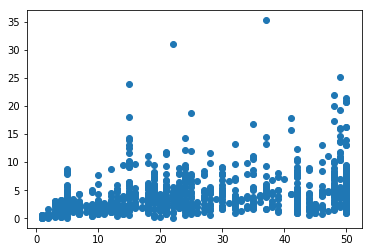

In [20]:
# distribution of all df versus velocity values 
plt.scatter(max_bins_relative_bins.loc['x'].values, max_bins_relative_bins.loc['y'].values)
plt.show()

In [32]:
#filter cells to show events above a z score threshold
z_score_threshold = 2
thresholded_bins = max_bins.transpose()[max_bins.loc['y'] > 2]
thresholded_bins = thresholded_bins.transpose()

In [33]:
thresholded_bins

GRIN013_H13_M33_S54                                              \
                       3          4          6          7          9     
y                 2.156276   2.536974   6.696357   4.194421   2.016543   
x                14.000000  16.000000  16.000000  16.000000  14.000000   
cm_sec            1.152704   1.329776   1.329776   1.329776   1.152704   

                                                               ...  \
              10         11         12         13         14   ...   
y        5.095806   3.364706   9.927230   3.756558   2.047984  ...   
x       28.000000  27.000000  28.000000  16.000000  14.000000  ...   
cm_sec   2.392208   2.303672   2.392208   1.329776   1.152704  ...   

       GRIN035_H14_M40_S34                                              \
                       105        106        109        110        66    
y                 3.947829   7.885160   3.044683   5.770407   4.117341   
x                18.000000  22.000000  21.000000  22.000000  25.000000   
cm_sec            1.506848   1.860992   1.772456   1.860992   2.126600   

                                                               
              116        123        126        134        121  
y        2.477609   2.103776   3.106887   4.549365   2.419023  
x       22.000000  18.000000  22.000000  25.000000  12.000000  
cm_sec   1.860992   1.506848   1.860992   2.126600   0.975632  

[3 rows x 596 columns]

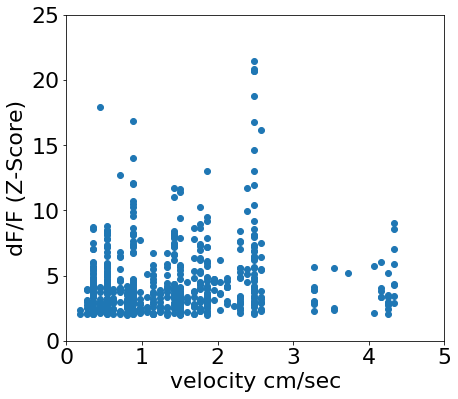

In [36]:
# distribution of all df versus velocity values 
plt.rcParams.update({'font.size': 22})
plt.scatter(thresholded_bins.loc['cm_sec'].values, thresholded_bins.loc['y'].values)
fig = plt.gcf()
fig.set_size_inches(7, 6)
plt.xlim((0, 5))
plt.ylim((0, 25))
ax = plt.gca()
ax.set_ylabel('dF/F (Z-Score)')
ax.set_xlabel('velocity cm/sec')
fig.subplots_adjust(left=0.15)
fig.savefig('/home/jma819/presentation_files/wt_c_by_v.pdf', transparent=True)
plt.show()

In [37]:
# load KO data 
ko_bins = pd.read_csv('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/indiv_cell_regressions/maxf_by_v_ko_1S_thresholded.csv', index_col=0)
ko_bins_relative = pd.read_csv('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/indiv_cell_regressions/maxf_by_v_rel_ko_1S.csv', index_col=0)

In [46]:
max_v_bins_cumulative = stats.cumfreq(max_bins.loc['cm_sec'].values, numbins=100, defaultreallimits=(0, 5))
max_v_bins_cumulative_relative = stats.cumfreq(max_bins_relative_bins.loc['x'].values, numbins=150, defaultreallimits=(0, 50))
ko_bins_cumulative = stats.cumfreq(ko_bins.loc['cm_sec'].values, numbins=100, defaultreallimits=(0, 5))
ko_bins_cumulative_relative = stats.cumfreq(np.array(ko_bins_relative.loc['x'].values, dtype=np.float64), numbins=150, defaultreallimits=(0, 50)) 

In [47]:
wt_data = max_v_bins_cumulative.cumcount/len(max_bins.loc['x'].values)
wt_data_relative = max_v_bins_cumulative_relative.cumcount/len(max_bins_relative_bins.loc['x'].values)
ko_data = ko_bins_cumulative.cumcount/len(ko_bins.loc['x'].values)
ko_data_relative = ko_bins_cumulative_relative.cumcount/len(ko_bins_relative.loc['x'].values)

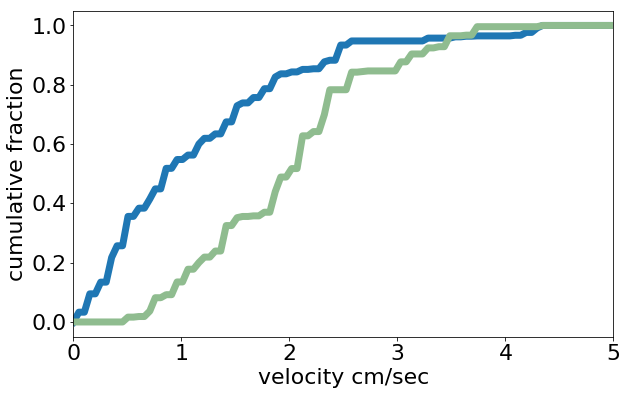

In [48]:
plt.rcParams.update({'font.size': 22})
plt.plot(np.linspace(0, 5, 100), wt_data, linewidth=7.0)
plt.plot(np.linspace(0, 5, 100), ko_data, color='darkseagreen', linewidth=7.0)
plt.xlim((0, 5))
fig = plt.gcf()
fig.set_size_inches(10, 6)
ax = plt.gca()
ax.set_ylabel('cumulative fraction')
ax.set_xlabel('velocity cm/sec')
fig.subplots_adjust(left=0.15)
fig.savefig('/home/jma819/presentation_files/df_binned_by_v.pdf', transparent=True)
plt.show()

In [49]:
stats.ks_2samp(wt_data, ko_data)

Ks_2sampResult(statistic=0.25, pvalue=0.0037294923618311367)

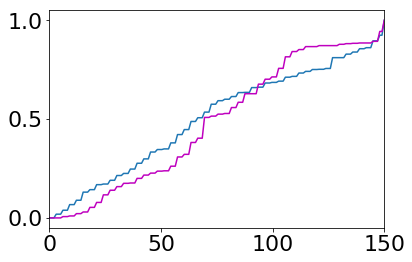

In [147]:
plt.plot(np.linspace(0, 150, 150), wt_data_relative)
plt.plot(np.linspace(0, 150, 150), ko_data_relative, color='m')
plt.xlim((0, 150))
plt.show()

In [148]:
stats.ks_2samp(wt_data_relative, ko_data_relative)

Ks_2sampResult(statistic=0.2, pvalue=0.0048579332350668775)

In [ ]:
# get curve for all cells
x = np.linspace(1, 50, 50)
trends_by_cell = {}
for session in list(grouped_raw_data.keys()):
    for cell in (by_cells_across_sessions[session].keys()):
        trends_by_cell[session+'_'+str(cell)] = by_cells_across_sessions[session][cell]['model'](x)
trendlines_by_cell = pd.DataFrame(trends_by_cell)

In [ ]:
# get curve for all cells
x = np.linspace(1, 50, 50)
trends_by_cell_significant = {}
for session in list(grouped_raw_data.keys()):
    for cell in (by_cells_across_sessions[session].keys()):
        if float(by_cells_across_sessions[session][cell]['statsmodel_results'].summary().tables[0][3][3].data)<0.5: 
            trends_by_cell_significant[session+'_'+str(cell)] = by_cells_across_sessions[session][cell]['model'](x)
trendlines_by_cell_significant = pd.DataFrame(trends_by_cell_significant)

In [ ]:
#maybe do analyze per animal by then group by range across all at end 
plt.plot(x, trendlines_by_cell.mean(axis=1))
mean = trendlines_by_cell.mean(axis=1)
std_error = (trendlines_by_cell.std(axis=1)/math.sqrt(4))
plt.fill_between(x, mean-std_error, mean+std_error)
plt.plot(x, trendlines_by_cell_significant.mean(axis=1), color='r')
mean_2 = trendlines_by_cell_significant.mean(axis=1)
std_error_2 = (trendlines_by_cell_significant.std(axis=1)/math.sqrt(4))
plt.fill_between(x, mean_2-std_error_2, mean_2+std_error_2)
plt.ylim([-1, 3])
plt.show()

In [158]:
list(grouped_raw_data.keys())

['GRIN013_H13_M33_S54',
 'GRIN027_H13_M29_S44',
 'GRIN026_H16_M35_S34',
 'GRIN033_H14_M34_S32',
 'GRIN033_H13_M42_S33',
 'GRIN032_H17_M30_S22',
 'GRIN032_H16_M49_S22',
 'GRIN034_H15_M28_S2',
 'GRIN034_H16_M13_S22',
 'GRIN034_H19_M0_S18',
 'GRIN035_H13_M50_S58',
 'GRIN035_H13_M31_S20',
 'GRIN035_H14_M40_S34']

In [190]:
## individual cell examples 

In [203]:
cell=100
df_to_fit = by_cells_across_sessions['GRIN032_H17_M30_S22'][cell]['fit_df']

In [204]:
df_to_fit

,y,x
1,0.343365,2.0
2,0.439387,3.0
3,0.506657,4.0
4,1.907827,5.0
6,2.042499,7.0
14,0.079734,15.0
15,0.280668,16.0
16,0.112850,17.0
22,1.344581,23.0
23,1.398712,24.0


In [227]:
#df_to_fit

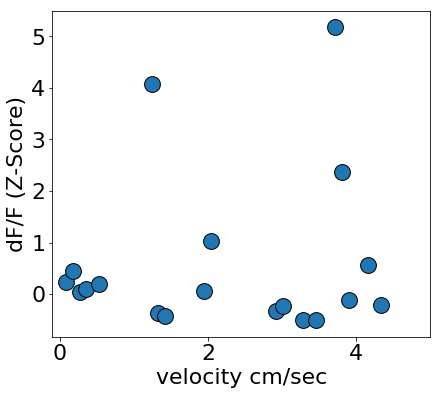

In [240]:
cell=1
df_to_fit = by_cells_across_sessions['GRIN032_H17_M30_S22'][cell]['fit_df']
binning_range = pd.interval_range(start=-1*0.0868, end=50*0.0868, periods=50)
end_points = {k:v for k,v in zip(np.linspace(1, 50, 50), [binning_range.values[interval].right for interval in range(len(binning_range))])}
df_to_fit['cm_sec'] = [end_points[df_to_fit['x'].values[point]] for point in range(len(df_to_fit['x'].values))]
plt.scatter(df_to_fit['cm_sec'].values, df_to_fit['y'].values, s=250, linewidths=1, edgecolors='k')
fig = plt.gcf()
fig.set_size_inches(7, 6)
plt.xlim((-.1, 5))
ax = plt.gca()
ax.set_ylabel('dF/F (Z-Score)')
ax.set_xlabel('velocity cm/sec')
fig.subplots_adjust(left=0.15)
fig.savefig('/home/jma819/presentation_files/indiv_cell_eg1.pdf', transparent=True)
plt.show()

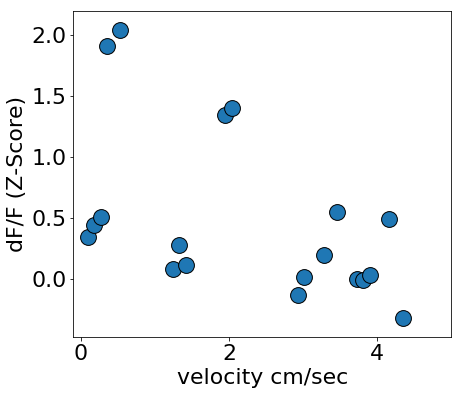

In [241]:
cell=100
df_to_fit = by_cells_across_sessions['GRIN032_H17_M30_S22'][cell]['fit_df']
binning_range = pd.interval_range(start=-1*0.0868, end=50*0.0868, periods=50)
end_points = {k:v for k,v in zip(np.linspace(1, 50, 50), [binning_range.values[interval].right for interval in range(len(binning_range))])}
df_to_fit['cm_sec'] = [end_points[df_to_fit['x'].values[point]] for point in range(len(df_to_fit['x'].values))]
plt.scatter(df_to_fit['cm_sec'].values, df_to_fit['y'].values, s=250, linewidths=1, edgecolors='k')
fig = plt.gcf()
fig.set_size_inches(7, 6)
plt.xlim((-.1, 5))
ax = plt.gca()
ax.set_ylabel('dF/F (Z-Score)')
ax.set_xlabel('velocity cm/sec')
fig.subplots_adjust(left=0.15)
fig.savefig('/home/jma819/presentation_files/indiv_cell_eg2.pdf', transparent=True)
plt.show()